#### Imports

In [1]:
#! pip install -r requirements.txt
#! pip install --force-reinstall -r requirements.txt

In [2]:
import numpy as np
import torch
import torch.nn as nn
import os
#import time

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from make_gif_from_folder import make_gif

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


#### Making of dataset

In [3]:
class MyPix(torch.utils.data.Dataset):
    def __init__(self, path_to_file, mode):
        self.img_array = np.array(ImageOps.grayscale(
            Image.open(path_to_file))).astype(int) if mode == 'img' else 255*self.read_from_abz(path_to_file)
        self.width, self.height = self.img_array.shape
        self.total_pixel = self.width * self.height
        self.bound_length = len(np.where(self.img_array < 255)[0])
        print(f'width = {self.width}\n' +
              f'height = {self.height}\n' +
              f'total_pixel = {self.total_pixel}\n' +
              f'bound length: {self.bound_length}\n' +
              f'percent of bound pixels: {(100 * self.bound_length / self.total_pixel):.1f}%')

        batch = np.stack(np.indices((self.width, self.height)),
                         axis=2).reshape(-1, 2)
        labels = np.zeros(len(batch))

        for idx, el in enumerate(batch):
            labels[idx] = 1 if self.img_array[el[0],
                                              el[1]] == 255 else 0  # 1 - bound

        batch = torch.from_numpy(batch).float()
        batch[:, 0] -= batch[:, 0].mean()
        batch[:, 0] /= batch[:, 0].max()
        batch[:, 1] -= batch[:, 1].mean()
        batch[:, 1] /= batch[:, 1].max()

        self.data = batch
        self.labels = torch.from_numpy(labels).float()

        self.grad_labels = torch.from_numpy(
            self._add_grad_label()).float().view(-1, 1)
        #self.grad_labels2 = self.add_grad_label()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.grad_labels[idx]

    def _add_grad_label(self):
        tmp = self.labels.numpy().reshape(self.img_array.shape)

        left_shift, right_shift, up_shift, down_shift = np.ones((4, self.width, self.height))

        result = np.zeros(self.img_array.shape)

        left_shift[:, :-1] = tmp[:, 1:]
        right_shift[:, 1:] = tmp[:, :-1]
        up_shift[1:, :] = tmp[:-1, :]
        down_shift[:-1, :] = tmp[1:, :]

        result = left_shift + right_shift + down_shift + up_shift - 4 * tmp
        result = np.zeros(self.img_array.shape) != result
        return result.astype(int)

    def show_image(self):
        plt.figure(figsize=(10, 5))
        plt.title('Input Image')
        plt.imshow(self.img_array, cmap='gray', vmin=0, vmax=255)

    def show_grad_labels(self):
        plt.figure(figsize=(10, 5))
        plt.title('Grad-points -- white')
        plt.imshow(self.grad_labels.view(self.img_array.shape),
                   cmap='gray', vmin=0, vmax=1)
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        img_arr = np.ones(my_shape)
        for line in lines[3:]:
            cur_line = [int(x) for x in line.split()]
            if len(cur_line) == 3:
                y = cur_line[0]
                x1 = cur_line[1]
                x2 = -cur_line[2]
                for i in range(x1, x2 + 1):
                    img_arr[min(y, my_shape[0]-1), min(i, my_shape[1]-1)] = 0
            elif len(cur_line) == 5:
                y = cur_line[0]
                x1 = cur_line[1]
                x2 = -cur_line[2]
                x3 = cur_line[3]
                x4 = -cur_line[4]
                for i in range(x1, x2 + 1):
                    img_arr[min(y, my_shape[0]-1), min(i, my_shape[1]-1)] = 0
                for i in range(x3, x4 + 1):
                    img_arr[min(y, my_shape[0]-1), min(i, my_shape[1]-1)] = 0
        return img_arr

#### Defining the Network

In [4]:
class Net(nn.Module):
    def __init__(self, dataset, lr, weight_decay):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 4), nn.ELU(),
            nn.Linear(4, 8), nn.ELU(),
            nn.Linear(8, 16), nn.ELU(),
            nn.Linear(16, 32), nn.ELU(),
            # nn.Linear(32, 64), nn.ELU(),
            # nn.Linear(64, 128), nn.ELU(),
            # nn.Linear(128, 64), nn.ELU(),
            # nn.Linear(64, 32), nn.ELU(),
            nn.Linear(32, 16), nn.ELU(),
            nn.Linear(16, 8), nn.ELU(),
            nn.Linear(8, 1), nn.Tanh())
        self.dataset = dataset
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)
        
    def forward(self, x):
        #x = x.cuda()
        output = self.net(x)
        return output

    def compute_loss(self, output, input, epoch, need_grad):
        mask = np.where(self.dataset.labels == 1)[0]
        bound_mask = np.where(self.dataset.labels == 0)[0]
        if need_grad:
            grad_mask = np.where(self.dataset.grad_labels == 0)[0]
        exterior_integral = 1 - (output[mask].abs()).sum() / (self.dataset.total_pixel - self.dataset.bound_length) # хочу НЕ границу +-1
        #d_bound = (data.grad[d_bound_mask, :].abs() / data.grad[d_bound_mask, :].max()).sum() / len(data.grad[d_bound_mask, :]) if epoch else 0
        #d_bound = ((data.grad[d_bound_mask, :] / data.grad[d_bound_mask, :].max()) / len(data.grad[d_bound_mask, :])).sum() if epoch else 0
        #if epoch > 1000:
        # boundgrad = data.grad[np.where(img_arr.reshape(-1, 1) < 255), :]
        # boundgrad = 1. / boundgrad.view(-1, 1).abs().sum() 
        # outgrad = data.grad[np.where(img_arr.reshape(-1, 1) == 255), :]
        # outgrad = outgrad.view(-1, 1).abs().sum() / (len(outgrad.view(-1, 1)))
        # else:
        #     mygrad = 0
        second_integral = output.sum().abs() / self.dataset.total_pixel #if epoch > 5000 else 0
        bound_intgegral = (output[bound_mask] ** 2).sum() / self.dataset.bound_length # хочу на границе 0
        grad_integral = input.grad[grad_mask].abs().sum() / (len(input.grad[grad_mask]) * input.grad[grad_mask].abs().max()) if need_grad else 0
        
        return bound_intgegral + exterior_integral + grad_integral + 1e-1*second_integral #+ 1e-1*second_integral# + boundgrad + outgrad #second_integral #+ mygrad 

    def go_train(self, num_epochs, show_frequency, need_grad):
        loss_trace = []

        batch = self.dataset.data.to(device)
        perm = torch.randperm(self.dataset.total_pixel)
        inv_perm = torch.argsort(perm)
        batch = batch[perm]
        
        if need_grad:
            batch.requires_grad_()

        dir_path = 'epoch_outs'
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

        for epoch in range(1, int(num_epochs) + 1):
            output = self(batch)
            if need_grad:
                output.sum().backward(retain_graph=True)

            self.optimizer.zero_grad()

            loss = self.compute_loss(output=output[inv_perm], input=batch, epoch=epoch, need_grad=need_grad)
            loss_trace.append(loss.item())
            loss.backward(retain_graph=True)

            self.optimizer.step()
            # scheduler.step(loss)

            if epoch % int(show_frequency) == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                #plt.ylim((0, 1))
                plt.plot(loss_trace)
                plt.subplot(1, 2, 2)
                plt.imshow(output[inv_perm].cpu().detach().numpy().reshape(self.dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1)
                plt.title(f'Epoch {epoch}')
                plt.colorbar()
                plt.savefig(dir_path + '/epoch%06d.png' % epoch)
                plt.show()

        return output

    def test_model(self):
        # batch = np.stack(np.indices((2 * 60, 2 * 80)), axis=2).reshape(-1, 2)
        # batch = torch.from_numpy(batch).float()
        # batch[:, 0] -= batch[:, 0].mean()
        # batch[:, 0] /= batch[:, 0].max()
        # batch[:, 1] -= batch[:, 1].mean()
        # batch[:, 1] /= batch[:, 1].max()
        with torch.no_grad():
            dbatch = self.dataset.data
            dbout = self(dbatch.cuda()).cpu().view((self.dataset.img_array.shape)).numpy()
            # bout = self(batch.cuda()).cpu().view((2*60,2*80)).numpy()
            # np.savetxt('out_true.txt', dbout, fmt='%.1f')
            # np.savetxt('out_test.txt', bout, fmt='%.1f')

            plt.figure(figsize=(12, 6))
            plt.title('Visualization of the function $f(x,y)$')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.imshow(dbout, cmap='PuOr', vmin=-1, vmax=1) 
            plt.colorbar()

        dbatch.requires_grad_()
        tmp = self(dbatch.cuda())
        tmp.sum().backward()

        test_output = dbatch.grad.cpu()

        plt.figure(figsize=(12, 6))
        #plt.subplot(3, 1, 1)
        plt.title(r'Gradient map for $\frac{\partial f}{\partial x}$', fontsize=30)
        plt.xlabel('x')
        plt.ylabel('y')
        my_limit = min(test_output[:, 0].max(), -test_output[:, 0].min())
        plt.imshow(test_output[:, 0].view((self.dataset.img_array.shape)), cmap='seismic', vmin=-my_limit, vmax=my_limit)
        plt.colorbar()

        plt.figure(figsize=(12, 6))
        #plt.subplot(3, 1, 2)
        plt.title(r'Gradient map for $\frac{\partial f}{\partial y}$', fontsize=30)
        plt.xlabel('x')
        plt.ylabel('y')
        my_limit = min(test_output[:, 1].max(), -test_output[:, 1].min())
        plt.imshow(test_output[:, 1].view((self.dataset.img_array.shape)), cmap='seismic', vmin=-my_limit, vmax=my_limit)
        plt.colorbar()

        plt.figure(figsize=(12, 6))
        #plt.subplot(3, 1, 3)
        plt.title(r'Gradient map for $\sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2}$', fontsize=30)
        plt.xlabel('x')
        plt.ylabel('y')

        plt.imshow(((test_output[:, 0] ** 2 + test_output[:, 1] ** 2) ** 0.5).view((self.dataset.img_array.shape)), cmap='plasma')
        plt.colorbar()


        return test_output

    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr


#### Initializing and training the network

width = 223
height = 378
total_pixel = 84294
bound length: 4347
percent of bound pixels: 5.2%


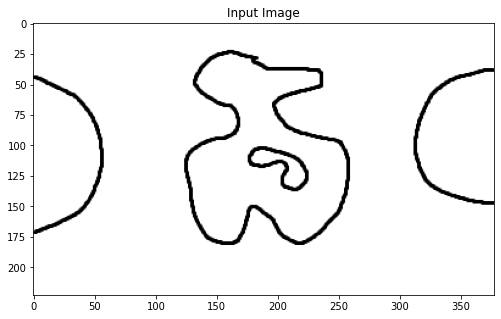

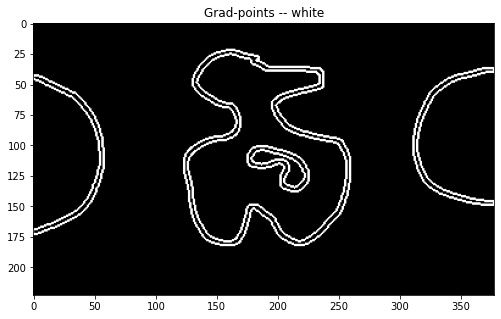

In [5]:
model = Net(dataset=MyPix(path_to_file='./imgs/1.png', mode='img'), lr=1e-3, weight_decay=1e-3)
model.to(device)
model.dataset.show_image()
model.dataset.show_grad_labels()
# model

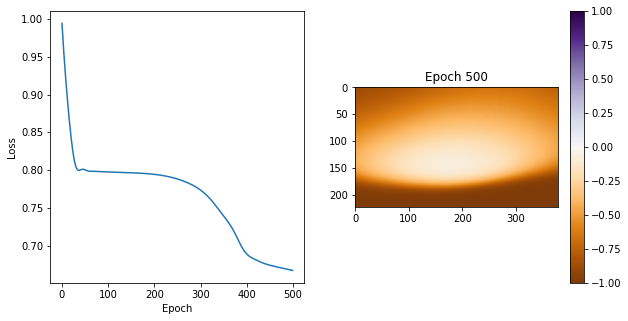

KeyboardInterrupt: 

In [6]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# model.change_lr(1e-4)
y_pred = model.go_train(num_epochs=1e+4, show_frequency=1e+2, need_grad=False)

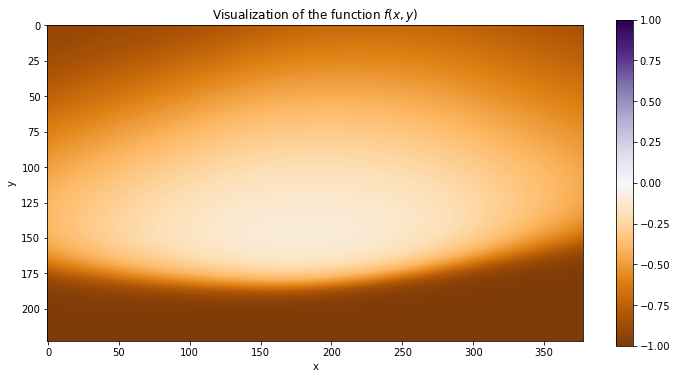

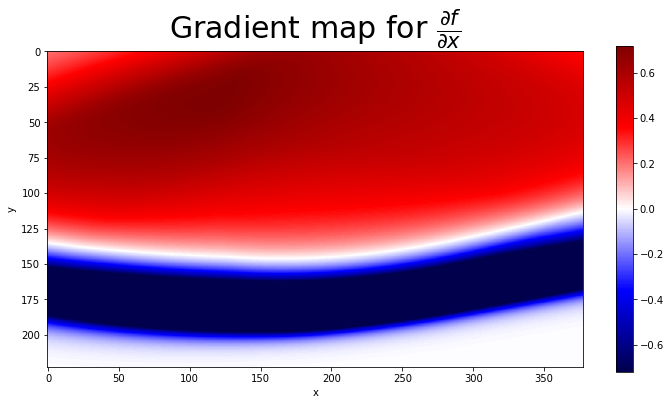

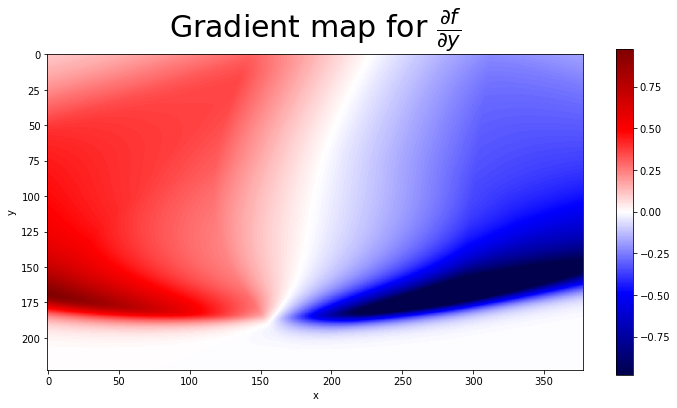

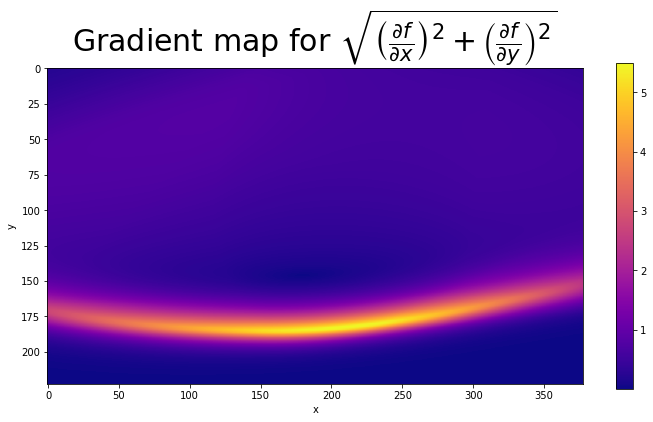

In [7]:
grad_out = model.test_model()

In [145]:
make_gif(dir_path='./epoch_outs', gifname='nice')

In [33]:
batch = model.dataset.data
batch
new_batch = np.zeros((len(batch.numpy()), 3))
for i, _ in enumerate(batch):
    x, y = _
    new_batch[i, 0] = np.cos(torch.pi * y)
    new_batch[i, 1] = np.sin(torch.pi * y)
    new_batch[i, 2] = x
new_batch

array([[-1.00000000e+00,  8.74227766e-08, -1.00000000e+00],
       [-9.97986674e-01, -6.34238645e-02, -1.00000000e+00],
       [-9.91954803e-01, -1.26592427e-01, -1.00000000e+00],
       ...,
       [-9.91954803e-01,  1.26592427e-01,  1.00000000e+00],
       [-9.97986674e-01,  6.34238645e-02,  1.00000000e+00],
       [-1.00000000e+00, -8.74227766e-08,  1.00000000e+00]])

In [34]:
import plotly.express as px

In [35]:
x, y, z = new_batch[:, 0], new_batch[:, 1], new_batch[:, 2]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, cmap = 'inferno', c=model.dataset.labels)

In [36]:
px.scatter_3d(new_batch, x, y, z, color=model.dataset.labels)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>z=%{z}<br>color=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
                         'coloraxis': 'coloraxis',
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([-1.        , -0.99798667, -0.9919548 , ..., -0.9919548 , -0.99798667,
                          -1.        ]),
              'y': array([ 8.74227766e-08, -6.34238645e-02, -1.26592427e-01, ...,  1.26592427e-01,
                           6.34238645e-02, -8.74227766e-08]),
              'z': array([-1., -1., -1., ...,  1.,  1.,  1.])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'color'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'scene': {'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
                         'xaxis': {'title': {'text': 'x'}},
                         'yaxis': {'title': {'text': 'y'}},
                         'zaxis': {'title': {'text': 'z'}}},
               'template': '...'}
})